In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt

1.12.1+cu113
     |████████████████████████████████| 7.9 MB 1.1 MB/s 
     |████████████████████████████████| 3.5 MB 1.2 MB/s 


In [2]:
!pip install -U hopsworks --quiet
import hopsworks
import pandas as pd

project = hopsworks.login()
fs = project.get_feature_store()

     |████████████████████████████████| 120 kB 7.0 MB/s 
     |████████████████████████████████| 50 kB 5.5 MB/s 
     |████████████████████████████████| 132 kB 36.5 MB/s 
     |████████████████████████████████| 45 kB 931 kB/s 
     |████████████████████████████████| 68 kB 3.9 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 4.9 MB 29.7 MB/s 
     |████████████████████████████████| 42 kB 1.2 MB/s 
     |████████████████████████████████| 2.8 MB 37.5 MB/s 
     |████████████████████████████████| 2.3 MB 24.6 MB/s 
     |████████████████████████████████| 109 kB 43.7 MB/s 
     |████████████████████████████████| 4.1 MB 27.2 MB/s 
     |████████████████████████████████| 140 kB 44.2 MB/s 
     |████████████████████████████████| 67 kB 1.8 MB/s 
     |████████████████████████████████| 1.6 MB 43.1 MB/s 
     |████████████████████████████████| 127 kB 46.6 MB/s 
     |████████████████████████████████| 500 kB 68.8 MB/s 
     |█████████████████████

Connected. Call `.close()` to terminate connection gracefully.


In [39]:
feature_view_name="trans_fraud"
def create_feature_view(feature_view_name, version):
    trans_fg = fs.get_feature_group(feature_view_name, version=version)
    fraud_label_fg = fs.get_feature_group('transactions_fraud_label', version=version) 
    
    # Load transformation functions.
    min_max_scaler = fs.get_transformation_function(name="min_max_scaler")
    label_encoder = fs.get_transformation_function(name="label_encoder")

    # Map features to transformations.
    transformation_functions = {
        'customer_id': label_encoder,
        'terminal_id': label_encoder,
        'tx_amount': min_max_scaler,
        'tx_time_seconds': min_max_scaler,
        'tx_time_days': min_max_scaler,
        'tx_fraud_scenario': min_max_scaler,
        'tx_during_weekend': min_max_scaler,
        'tx_during_night': min_max_scaler,
        'customer_id_nb_tx_1day_window': min_max_scaler,
        'customer_id_avg_amount_1day_window': min_max_scaler,
        'customer_id_nb_tx_7day_window': min_max_scaler,
        'customer_id_avg_amount_7day_window': min_max_scaler,
        'customer_id_nb_tx_30day_window': min_max_scaler,
        'customer_id_avg_amount_30day_window': min_max_scaler,
        'terminal_id_nb_tx_1day_window': min_max_scaler,
        'terminal_id_risk_1day_window': min_max_scaler,
        'terminal_id_nb_tx_7day_window': min_max_scaler,
        'terminal_id_risk_7day_window': min_max_scaler,
        'terminal_id_nb_tx_30day_window': min_max_scaler,
        'terminal_id_risk_30day_window': min_max_scaler
    }
    # Select features for training data.
    ds_query = trans_fg.select_all()
    #, prefix="ken") \
    # ds_query.show(5)
    return fs.create_feature_view(
        name=feature_view_name,
        query=ds_query,
        labels=["tx_fraud"],
        transformation_functions=transformation_functions
    )

try:
    feature_view = fs.get_feature_view(name=feature_view_name, version=1)
except:
    feature_view = create_feature_view(feature_view_name, 1)

print(feature_view.query.to_string())

SELECT `fg0`.`transaction_id` `transaction_id`, `fg0`.`tx_datetime` `tx_datetime`, `fg0`.`customer_id` `customer_id`, `fg0`.`terminal_id` `terminal_id`, `fg0`.`tx_amount` `tx_amount`, `fg0`.`tx_time_seconds` `tx_time_seconds`, `fg0`.`tx_time_days` `tx_time_days`, `fg0`.`tx_fraud` `tx_fraud`, `fg0`.`tx_fraud_scenario` `tx_fraud_scenario`, `fg0`.`tx_during_weekend` `tx_during_weekend`, `fg0`.`tx_during_night` `tx_during_night`, `fg0`.`customer_id_nb_tx_1day_window` `customer_id_nb_tx_1day_window`, `fg0`.`customer_id_avg_amount_1day_window` `customer_id_avg_amount_1day_window`, `fg0`.`customer_id_nb_tx_7day_window` `customer_id_nb_tx_7day_window`, `fg0`.`customer_id_avg_amount_7day_window` `customer_id_avg_amount_7day_window`, `fg0`.`customer_id_nb_tx_30day_window` `customer_id_nb_tx_30day_window`, `fg0`.`customer_id_avg_amount_30day_window` `customer_id_avg_amount_30day_window`, `fg0`.`terminal_id_nb_tx_1day_window` `terminal_id_nb_tx_1day_window`, `fg0`.`terminal_id_risk_1day_window` `t

In [40]:
#td_version, td_job = feature_view.create_train_test_split(
#    description = 'transactions fraud batch training dataset',
#    data_format = "csv",
#    test_size = 0.2,
#    coalesce = True,
#    statistics_config={
#        "enabled": True,
#        "histograms": False,
#        "correlations": False
#    }    
#)
#X_train, X_test, y_train, y_test = feature_view.get_train_test_split(training_dataset_version=td_version)

import datetime
from datetime import date
import pandas as pd

BEGIN_DATE = "2018-06-11"
END_DATE = "2018-09-14"

start_date = pd.datetime.fromisoformat(BEGIN_DATE)
end_date =  pd.datetime.fromisoformat(END_DATE)
print(start_date)
print(end_date)

def date_to_timestamp(date_obj: datetime)-> int:
    return int(date_obj.timestamp() * 1000)

#start_date = (datetime.datetime.now() - datetime.timedelta(hours=24))  
#end_date = (datetime.datetime.now()) 
start_date = date_to_timestamp(start_date)
end_date =  date_to_timestamp(end_date)

td_version, td_job = feature_view.create_training_data(
    start_time=start_date,
    end_time=end_date,
    description = 'transactions fraud batch training dataset',
    storage_connector=None,
    location="",
    data_format="csv",
    coalesce=False,
    seed=None,
    statistics_config=None,
    write_options={},
)

X_train, y_train = feature_view.get_training_data(training_dataset_version=td_version, read_options=None)

2018-06-11 00:00:00
2018-09-14 00:00:00
Training dataset job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/3339/jobs/named/trans_fraud_1_2_create_fv_td_05112022151413/executions


In [41]:
X_train

,transaction_id,tx_datetime,customer_id,terminal_id,tx_amount,tx_time_seconds,tx_time_days,tx_fraud_scenario,tx_during_weekend,tx_during_night,...,customer_id_nb_tx_7day_window,customer_id_avg_amount_7day_window,customer_id_nb_tx_30day_window,customer_id_avg_amount_30day_window,terminal_id_nb_tx_1day_window,terminal_id_risk_1day_window,terminal_id_nb_tx_7day_window,terminal_id_risk_7day_window,terminal_id_nb_tx_30day_window,terminal_id_risk_30day_window
0,844541,1530160511000,477,192,0.058377,0.788403,6,3,1,0,...,0.549020,0.070446,0.671141,0.114370,0.222222,0.0,0.375000,0.0,0.449275,0.000000
1,817495,1529914967000,2527,9500,0.152023,0.630508,0,3,1,1,...,0.235294,0.257869,0.281879,0.357441,0.000000,0.0,0.166667,0.0,0.188406,0.000000
2,831438,1530024895000,60,7133,0.109687,0.701197,5,3,1,1,...,0.019608,0.250308,0.067114,0.369028,0.111111,0.0,0.416667,0.0,0.405797,0.000000
3,835122,1530076154000,4103,9056,0.002151,0.734158,8,3,1,0,...,0.549020,0.160025,0.590604,0.236992,0.333333,0.0,0.375000,0.0,0.492754,0.000000
4,727999,1529090730000,890,1879,0.009146,0.100490,13,3,1,1,...,0.372549,0.089978,0.644295,0.138991,0.111111,0.0,0.208333,0.0,0.275362,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172855,874674,1530429688000,2465,7915,0.044242,0.961495,4,3,0,1,...,0.372549,0.183893,0.523490,0.307475,0.111111,0.0,0.541667,0.0,0.565217,0.000000
172856,732300,1529143654000,879,3792,0.023403,0.134522,3,3,0,1,...,0.568627,0.049432,0.838926,0.058912,0.000000,0.0,0.250000,0.0,0.362319,0.000000
172857,851242,1530201471000,136,1426,0.032930,0.814742,6,3,1,1,...,0.411765,0.079378,0.550336,0.112921,0.000000,0.0,0.291667,0.0,0.318841,0.037048
172858,743084,1529235517000,667,5505,0.033831,0.193594,9,3,0,1,...,0.490196,0.034551,0.563758,0.055412,0.111111,0.0,0.208333,0.0,0.478261,0.000000


In [11]:
output_feature="TX_FRAUD"
output_feature=output_feature.lower()

input_features=['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']

input_features=[x.lower() for x in input_features]
print(input_features)

['tx_amount', 'tx_during_weekend', 'tx_during_night', 'customer_id_nb_tx_1day_window', 'customer_id_avg_amount_1day_window', 'customer_id_nb_tx_7day_window', 'customer_id_avg_amount_7day_window', 'customer_id_nb_tx_30day_window', 'customer_id_avg_amount_30day_window', 'terminal_id_nb_tx_1day_window', 'terminal_id_risk_1day_window', 'terminal_id_nb_tx_7day_window', 'terminal_id_risk_7day_window', 'terminal_id_nb_tx_30day_window', 'terminal_id_risk_30day_window']


In [14]:
#import sklearn
#from sklearn.preprocessing import StandardScaler

#transactions_df = X_train

#print(transactions_df.tx_amount.value_counts())
#print( transactions_df.shape)
# By default, scaling the input data

#scaler = sklearn.preprocessing.StandardScaler()
#scaler.fit(transactions_df[input_features])
#transactions_df[input_features]=scaler.transform(transactions_df[input_features])

#print(transactions_df.tx_amount.value_counts())

69.000     107
68.500     104
68.750     102
67.000     101
65.250      95
          ... 
395.250      1
377.500      1
516.500      1
204.375      1
199.000      1
Name: tx_amount, Length: 5635, dtype: int64
(172860, 22)
0.370544     107
0.358567     104
0.364555     102
0.322637     101
0.280718      95
            ... 
8.185373       1
7.760199       1
11.089735      1
3.613249       1
3.484499       1
Name: tx_amount, Length: 5635, dtype: int64


🥳  READ YAML conf from Github or S3 (Retool)

In [42]:
import numpy as np

## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

transactions_df = pd.DataFrame(data=X_train)

transactions_df = reduce_mem_usage(transactions_df)

Mem. usage decreased to  7.91 Mb (72.7% reduction)


In [43]:
def prepare_edge(df):
  # step 1 read from gsheet the expert rule
  # step 2 grouped = test.groupby([expert rule])
  # step 3 one edged graph -- one model 
  return True


from sklearn.metrics.pairwise import cosine_similarity

train_df = transactions_df

test= train_df[['transaction_id','tx_amount','customer_id','terminal_id']] #.head(10000)
test = test.reset_index(drop=True)
print( test.head(2))

test['abs_tx_amount'] = test['tx_amount'].abs()
print( test.shape)

df_edges = pd.DataFrame(columns=['txId1','txId2'])

#grouped = test.groupby('tx_amount')
grouped = test.groupby(['abs_tx_amount','customer_id'])
for name,group in grouped:
    if group.shape[0] >= 2:
        res = group.transpose().agg(np.mean)
        feature_to_comp = ['abs_tx_amount','terminal_id']
        tradeoff = 1 - 0.2
        temp_group_df = group[feature_to_comp].copy()
        cosine = cosine_similarity(temp_group_df)
        customers = group.customer_id.unique()
        for value in customers :
            rest = group.loc[group['customer_id'] == value]
        # make edge between each row trxid if cosine > tradeoff
        result = np.where(cosine >  tradeoff)
        for i in range(len(result[0])):
            if result[0][i] != result[1][i] : 
                df_edges = df_edges.append({'txId1': group.iloc[result[0][i]].name,'txId2':group.iloc[result[1][i]].name}, ignore_index=True)



mapping = {idx: i for i, idx in enumerate(test.transaction_id)}

# mapping nodes to indices
nodes = test.transaction_id.values
map_id = {i:j for i,j in enumerate(nodes)}

edges = df_edges.copy()
print(edges.head())
print(edges.txId1[0])
print(edges.txId2[0])

edges['txId1'] =  edges['txId1'].astype(int) #  edges['txId1'].map(map_id)
edges['txId2'] = edges['txId2'].astype(int) # .map(map_id)
print(edges.head())

edge_index = np.array(edges.values).T
edge_index = torch.tensor(edge_index, dtype=torch.long).contiguous()

# weights for the edges are equal in case of model without attention
weights = torch.tensor([1] * edge_index.shape[1] , dtype=torch.float32)
print("Total amount of edges in DAG:", edge_index.shape)

   transaction_id  tx_amount  customer_id  terminal_id
0          844541   0.058380          477          192
1          817495   0.151978         2527         9500
(172860, 5)
    txId1   txId2
0  103487  118777
1  118777  103487
2  126151  146262
3  146262  126151
4   65515  144942
103487
118777
    txId1   txId2
0  103487  118777
1  118777  103487
2  126151  146262
3  146262  126151
4   65515  144942
Total amount of edges in DAG: torch.Size([2, 3928])


In [44]:
# maping node ids to corresponding indexes

node_features = train_df.reset_index(drop=True).copy() #.drop(['txId'], axis=1).copy()
node_features[0] = node_features.index.map(map_id)
node_features['tx_fraud'] = pd.DataFrame(data=y_train)
print(node_features.index)
print(node_features.head(5))

print( node_features.tx_fraud.value_counts())

classified_idx = node_features.sample(frac=0.75, replace=False, random_state=1).index
#classified_idx = node_features.iloc[:].index
print(classified_idx)

#classified_idx = node_features['tx_fraud'].loc[node_features['tx_fraud']==0].index
temp_list = ~node_features.index.isin(classified_idx)
unclassified_idx = node_features[temp_list].index  #temp_list.loc[temp_list['tx_fraud']==0].index

# replace unkown class with 0, to avoid having 3 classes, this data/labels never used in training
# node_features['tx_fraud'] = node_features['tx_fraud'].replace(2, 0) 

labels = node_features['tx_fraud'].values

# drop indeces, class and temporal axes 
node_features = torch.tensor(np.array(node_features[input_features].values, dtype=np.float32), dtype=torch.float32)
print(node_features.shape)

RangeIndex(start=0, stop=172860, step=1)
   transaction_id    tx_datetime  customer_id  terminal_id  tx_amount  \
0          844541  1530160511000          477          192   0.058380   
1          817495  1529914967000         2527         9500   0.151978   
2          831438  1530024895000           60         7133   0.109680   
3          835122  1530076154000         4103         9056   0.002151   
4          727999  1529090730000          890         1879   0.009148   

   tx_time_seconds  tx_time_days  tx_fraud_scenario  tx_during_weekend  \
0         0.788574             6                  3                  1   
1         0.630371             0                  3                  1   
2         0.701172             5                  3                  1   
3         0.734375             8                  3                  1   
4         0.100464            13                  3                  1   

   tx_during_night  ...  customer_id_nb_tx_30day_window  \
0               

In [45]:
from torch_geometric.data import Data, DataLoader

print(node_features.shape)
 
print(labels.shape)

# converting data to PyGeometric graph data format
elliptic_dataset = Data(x = node_features, 
                        edge_index = edge_index, 
                        edge_attr = weights,
                        y = torch.tensor(labels, dtype=torch.float32)) 

print(f'Number of nodes: {elliptic_dataset.num_nodes}')
print(f'Number of node features: {elliptic_dataset.num_features}')
print(f'Number of edges: {elliptic_dataset.num_edges}')
print(f'Number of edge features: {elliptic_dataset.num_features}')
print(f'Average node degree: {elliptic_dataset.num_edges / elliptic_dataset.num_nodes:.2f}')
print(f'Number of classes: {len(np.unique(elliptic_dataset.y))}')
print(f'Has isolated nodes: {elliptic_dataset.has_isolated_nodes()}')
print(f'Has self loops: {elliptic_dataset.has_self_loops()}')
print(f'Is directed: {elliptic_dataset.is_directed()}')

torch.Size([172860, 15])
(172860,)
Number of nodes: 172860
Number of node features: 15
Number of edges: 3928
Number of edge features: 15
Average node degree: 0.02
Number of classes: 2
Has isolated nodes: True
Has self loops: False
Is directed: False


In [46]:
from torch_geometric.nn import GCNConv, GATv2Conv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    """Graph Convolutional Network"""
    def __init__(self, dim_in, dim_h, dim_out):
        super(GCN, self).__init__()
        
        self.gcn1 = GCNConv(dim_in, dim_h)
        self.gcn2 = GCNConv(dim_h, dim_out)
        
    def forward(self, x, edge_index):
        h = self.gcn1(x, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.6, training=self.training)
        out = self.gcn2(h, edge_index)
        return out

def accuracy(y_pred, y_test, prediction_threshold=0.5):
    y_pred_label = (torch.sigmoid(y_pred) > prediction_threshold).float()*1

    correct_results_sum = (y_pred_label == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]

    return acc

def train_evaluate(model, data, criterion, optimizer, *args):
    num_epochs = args[0]
    checkpoints_dir = args[1]
    model_filename = args[2]

    best_model_wts = copy.deepcopy(model.state_dict())

    best_loss = 10e10

    if not os.path.exists(checkpoints_dir):
        os.makedirs(checkpoints_dir)

    model.train()
    for epoch in range(num_epochs+1):
        # Training
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_idx], data.y[data.train_idx].unsqueeze(1))
        acc = accuracy(out[data.train_idx], data.y[data.train_idx].unsqueeze(1), prediction_threshold=0.5)
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_idx], data.y[data.val_idx].unsqueeze(1))
        val_acc = accuracy(out[data.val_idx], data.y[data.val_idx].unsqueeze(1), prediction_threshold=0.5)

        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')
        
            if val_loss < best_loss:
                best_loss = val_loss
                print("Saving model for best loss")
                checkpoint = {
                    'state_dict': best_model_wts
                }
                torch.save(checkpoint, os.path.join(checkpoints_dir, model_filename))
                best_model_wts = copy.deepcopy(model.state_dict())

    return model

def test(model, data):
    model.eval()
    out = model(data.x, data.edge_index) 
    preds = ((torch.sigmoid(out) > 0.5).float()*1).squeeze(1)
    return preds    

In [47]:
from sklearn.model_selection import train_test_split
import os
import copy

class Config:
    seed = 0
    learning_rate = 0.001
    weight_decay = 1e-5
    input_dim = 15
    output_dim = 1
    hidden_size = 128
    num_epochs = 100
    checkpoints_dir = './models/elliptic_gnn'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
print("Using device:", Config.device)


y_train = labels[classified_idx]

print(node_features[classified_idx].shape)
print(y_train.shape)
print(classified_idx)

# spliting train set and validation set
_, _, _, _, train_idx, valid_idx = \
    train_test_split(node_features[classified_idx], 
                     y_train, 
                     classified_idx, 
                     test_size=0.15, 
                     random_state=Config.seed, 
                     stratify=y_train)

elliptic_dataset.train_idx = torch.tensor(train_idx, dtype=torch.long)
elliptic_dataset.val_idx = torch.tensor(valid_idx, dtype=torch.long)
elliptic_dataset.test_idx = torch.tensor(unclassified_idx, dtype=torch.long)

print("Train dataset size:", elliptic_dataset.train_idx.shape[0])
print("Validation dataset size:", elliptic_dataset.val_idx.shape[0])
print("Test dataset size:", elliptic_dataset.test_idx.shape[0])

print("Total datasets size ", elliptic_dataset.train_idx.shape[0] + elliptic_dataset.val_idx.shape[0] + elliptic_dataset.test_idx.shape[0])

Using device: cpu
torch.Size([129645, 15])
(129645,)
Int64Index([ 73971,   4241, 165741,   7580, 151545,  94111,  97666, 169131,
             20431,  66537,
            ...
            128739,   3733, 149112,  66927, 135356, 105622,  52605, 164699,
            157811,   5217],
           dtype='int64', length=129645)
Train dataset size: 110198
Validation dataset size: 19447
Test dataset size: 43215
Total datasets size  172860


In [48]:
gcn_model = GCN(Config.input_dim, Config.hidden_size, Config.output_dim).to(Config.device)
data_train = elliptic_dataset.to(Config.device)

optimizer = torch.optim.Adam(gcn_model.parameters(), lr=Config.learning_rate, weight_decay=Config.weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
criterion = torch.nn.BCEWithLogitsLoss()

train_evaluate(gcn_model,
              data_train,
              criterion,
              optimizer,
              Config.num_epochs,
              Config.checkpoints_dir,
              'gcn_best_model.pth.tar')

Epoch   0 | Train Loss: 0.543 | Train Acc:  92.75% | Val Loss: 0.54 | Val Acc: 92.81%
Saving model for best loss
Epoch  10 | Train Loss: 0.379 | Train Acc:  99.09% | Val Loss: 0.38 | Val Acc: 99.09%
Saving model for best loss
Epoch  20 | Train Loss: 0.259 | Train Acc:  99.12% | Val Loss: 0.26 | Val Acc: 99.12%
Saving model for best loss
Epoch  30 | Train Loss: 0.177 | Train Acc:  99.12% | Val Loss: 0.18 | Val Acc: 99.12%
Saving model for best loss
Epoch  40 | Train Loss: 0.123 | Train Acc:  99.12% | Val Loss: 0.12 | Val Acc: 99.12%
Saving model for best loss
Epoch  50 | Train Loss: 0.091 | Train Acc:  99.12% | Val Loss: 0.09 | Val Acc: 99.12%
Saving model for best loss
Epoch  60 | Train Loss: 0.071 | Train Acc:  99.12% | Val Loss: 0.07 | Val Acc: 99.13%
Saving model for best loss
Epoch  70 | Train Loss: 0.060 | Train Acc:  99.12% | Val Loss: 0.06 | Val Acc: 99.13%
Saving model for best loss
Epoch  80 | Train Loss: 0.054 | Train Acc:  99.12% | Val Loss: 0.06 | Val Acc: 99.14%
Saving mod

GCN(
  (gcn1): GCNConv(15, 128)
  (gcn2): GCNConv(128, 1)
)

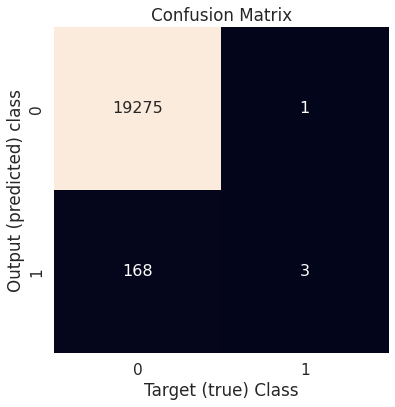

              precision    recall  f1-score   support

       licit       0.99      1.00      1.00     19276
     illicit       0.75      0.02      0.03       171

    accuracy                           0.99     19447
   macro avg       0.87      0.51      0.51     19447
weighted avg       0.99      0.99      0.99     19447

Test data fraud cases, percentage: 0.016198079370588918 %


In [49]:



from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns


gcn_model.load_state_dict(torch.load(os.path.join(Config.checkpoints_dir, 'gcn_best_model.pth.tar'))['state_dict'])

y_test_preds = test(gcn_model, data_train)

# confusion matrix on validation data
y_test = data_train.y[data_train.val_idx].detach().tolist()
y_pred = y_test_preds[valid_idx].detach().tolist()

conf_mat = confusion_matrix(y_test, y_pred)

report_dict = classification_report(y_test, y_pred, output_dict=True)

fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.4)
sns.heatmap(conf_mat, annot=True, fmt=".0f", annot_kws={"size": 16}, cbar=False)
plt.xlabel('Target (true) Class'); plt.ylabel('Output (predicted) class'); plt.title('Confusion Matrix')
plt.show();

print(classification_report(y_test,
                            y_pred,
                            target_names=['licit', 'illicit']))


print(f"Test data fraud cases, percentage: {y_test_preds[data_train.test_idx].detach().cpu().numpy().sum() / len(data_train.y[data_train.test_idx]) *100} %")

In [50]:
print(report_dict)


def register_python_model(model, name, description, features, labels, metrics):
    from hsml.schema import Schema
    from hsml.model_schema import ModelSchema
    import os
    import joblib
    import shutil

    mr = project.get_model_registry()

    model_dir= name + "_model"
    if os.path.isdir(model_dir) == False:
        os.mkdir(model_dir)
    pickle= name + '_model.pkl'
    # This will strip out the sml directory, copying only the files
    #shutil.copytree("sml", model_dir, dirs_exist_ok=True) #python 3.8+

    joblib.dump(model, model_dir + "/" + pickle)

    input_example = features.sample()
    input_schema = Schema(features)
    output_schema = Schema(labels)
    model_schema = ModelSchema(input_schema, output_schema)

    fraud_model = mr.python.create_model(
        name="fraud", 
        metrics=metrics,
        model_schema=model_schema,
        input_example=input_example, 
        description=description)

    # Save all artifacts in the model directory to the model registry
    fraud_model.save(model_dir)


register_python_model(gcn_model, "model", "Fraud Predictor", X_train, y_train, report_dict['0.0'])

{'0.0': {'precision': 0.9913593581237463, 'recall': 0.999948122017016, 'f1-score': 0.9956352178517007, 'support': 19276}, '1.0': {'precision': 0.75, 'recall': 0.017543859649122806, 'f1-score': 0.03428571428571428, 'support': 171}, 'accuracy': 0.9913097135805008, 'macro avg': {'precision': 0.8706796790618732, 'recall': 0.5087459908330694, 'f1-score': 0.5149604660687075, 'support': 19447}, 'weighted avg': {'precision': 0.9892370539000018, 'recall': 0.9913097135805008, 'f1-score': 0.987181946647413, 'support': 19447}}
Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://c.app.hopsworks.ai:443/p/3339/models/fraud/4


test 

In [25]:
fig = ax.get_figure()
fig.savefig("./models/confusion_matrix.png") 
fig.show()

In [ ]:
# authenticate
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

# create, and save df
from gspread_dataframe import set_with_dataframe
title = 'New Sheet'
gc.create(title)  # if not exist
sheet = gc.open(title).sheet1
set_with_dataframe(sheet, transactions_df.head(5)) 

In [ ]:
from gspread_dataframe import get_as_dataframe
sheet = gc.open(title).sheet1
df = get_as_dataframe(sheet).head(5)
df

,transaction_id,tx_datetime,customer_id,terminal_id,tx_amount,tx_time_seconds,tx_time_days,tx_fraud_scenario,tx_during_weekend,tx_during_night,...,terminal_id_nb_tx_1day_window,terminal_id_risk_1day_window,terminal_id_nb_tx_7day_window,terminal_id_risk_7day_window,terminal_id_nb_tx_30day_window,terminal_id_risk_30day_window,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
0,748086.0,2018-06-18 0:13:47,4077.0,4517.0,82.8125,6740027.0,78.0,0.0,0.0,1.0,...,1.0,0.0,8.0,0.0,28.0,0.0,NaN,NaN,NaN,NaN
1,722543.0,2018-06-15 9:50:12,2173.0,891.0,21.3125,6515412.0,75.0,0.0,0.0,0.0,...,1.0,0.0,8.0,0.0,27.0,0.0,NaN,NaN,NaN,NaN
2,729537.0,2018-06-16 4:35:05,2097.0,642.0,77.6250,6582905.0,76.0,0.0,1.0,1.0,...,1.0,0.0,6.0,0.0,32.0,0.0,NaN,NaN,NaN,NaN
3,784856.0,2018-06-21 17:19:00,2225.0,7847.0,98.6250,7060740.0,81.0,0.0,0.0,0.0,...,0.0,0.0,9.0,0.0,34.0,0.0,NaN,NaN,NaN,NaN
4,740043.0,2018-06-17 6:48:51,83.0,2019.0,72.1875,6677331.0,77.0,0.0,1.0,1.0,...,0.0,0.0,6.0,0.0,22.0,0.0,NaN,NaN,NaN,NaN


⏭️ Next:  Graph *export*


In [ ]:
import networkx as nx

df_sim = train_df[train_df['tx_fraud'] == 1]
#print(df_sim.head())

def weekday(tx_datetime):
    
    # Transform date into weekday (0 is Monday, 6 is Sunday)
    weekday = tx_datetime.weekday()
    
    return int(weekday)


df_sim = train_df[train_df['tx_amount'] > 1]
df_sim2 = df_sim[["TX_DATETIME","transaction_id","tx_amount", "customer_id", "terminal_id"]]
df_sim2 = df_sim2.head(10000)

#print(df_sim2.TX_DATETIME)
#print(df_sim2.TX_DATETIME.apply(weekday))


def rolling(df):
    uniques_customer_id = df.customer_id.value_counts().index
    print(uniques_customer_id)
    count = 0
    
    for customer_id in uniques_customer_id:
        dataf = df.loc[df['customer_id'] == int(customer_id) ]
        dataf = dataf.copy()
        dataf.TX_DATETIME =  pd.to_datetime(dataf.TX_DATETIME)
        dataf = dataf.set_index('TX_DATETIME')
        
        if dataf.shape[0] > 5 :
            #print(dataf)
            #val = dataf.rolling('1d', min_periods=2)['tx_amount'].sum()
            #dataf.rolling(1, min_periods=1, step=1).sum()
            dataf.resample('1h')['tx_amount'].sum()
            dataf.resample('D')['tx_amount'].sum()
            dataf.resample('7D')['tx_amount'].sum()
            print(dataf.resample('1h')['tx_amount'].count())
            dataf.resample('D')['tx_amount'].sum()
            dataf.resample('7D')['tx_amount'].sum()
            count = count +1 

        
    print(count)
    return 

rolling(df_sim2)

df_sim2["tx_amount"] = df_sim2["tx_amount"].astype(int)

In [ ]:
G = nx.from_pandas_edgelist(df_sim2, "transaction_id", "customer_id" )


df_attributes_only = df_sim2.copy()
#print(df_attributes_only )
node_attr = df_attributes_only.set_index('transaction_id').to_dict('index')
#print(node_attr)
nx.set_node_attributes(G, node_attr)

#print(df_sim2["tx_amount"].value_counts())

nx.draw(G,node_size =20)
nx.write_gexf(G, "test.gexf")

#https://ouestware.gitlab.io/retina/beta/#/graph/?r=d&url=https%3A%2F%2Fouestware.gitlab.io%2Fretina%2Fbeta%2Fdataset.gexf

⏭️ Next:  Rules *importer*


⏭️ Next:  Feature *engineering* EXT


In [ ]:
jsonsimon = train_df[train_df['tx_fraud'] == 1].head().to_json(orient="columns") #/*".[0-9][0-9][0-9][0-9][0-9]":
parsed = json.loads(jsonsimon)
json.dumps(parsed) 
